# **Analyze Taylor Swift Lyrics with Python**

### Try some of these resources for extra help as you work:

* [View the Analyze Taylor Swift Lyrics with Python Cheatsheet](https://www.codecademy.com/learn/case-study-analyze-taylor-swift-lyrics/modules/analyze-taylor-swift-lyrics/cheatsheet)
* Learn more about analyzing text in [Apply Natural Language Processing with Python](https://www.codecademy.com/learn/paths/natural-language-processing)

[View the solution notebook](./solution.html)

[The original dataset was curated by Jan Llenzl Dagohoy and published on Kaggle](https://www.kaggle.com/datasets/thespacefreak/taylor-swift-song-lyrics-all-albums)

##**Import Libraries**

In [ ]:
%matplotlib inline

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Taylor Data/

/content/drive/MyDrive/Taylor Data


#**Load the dataset**

In [ ]:
# load dataset
import pandas as pd
import glob
import os
path = r'/content/drive/MyDrive/Taylor Data/' # use your path

all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

##***Inspect the first few rows***

In [ ]:
df.head()

,album_name,track_title,track_n,lyric,line
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1
1,Red (Deluxe Edition),State of Grace,1,Busy streets and busy lives,2
2,Red (Deluxe Edition),State of Grace,1,And all we know is touch and go,3
3,Red (Deluxe Edition),State of Grace,1,We are alone with our changing minds,4
4,Red (Deluxe Edition),State of Grace,1,We fall in love 'til it hurts or bleeds,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9383 entries, 0 to 9382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   9383 non-null   object
 1   track_title  9383 non-null   object
 2   track_n      9383 non-null   int64 
 3   lyric        9383 non-null   object
 4   line         9383 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 366.6+ KB


 ## ***Get a list of all the albums in this collection***

In [ ]:
album_names = set(df.album_name)
album_names

{'1989 (Deluxe)',
 'Fearless (Taylor’s Version)',
 'Lover',
 'Midnights (3am Edition)',
 'Red (Deluxe Edition)',
 'Speak Now (Deluxe)',
 'Taylor Swift',
 'evermore (deluxe version)',
 'folklore (deluxe version)',
 'reputation'}

In [ ]:
def album_release(row):  
    if row["album_name"] == "Taylor Swift":
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    #ok, we know folklore was actually released in Dec 2020, but this will make our analysis easier
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021'
    #this is slightly differently formatted because the album name is recorded two ways.
    elif 'Midnights (3am Edition)' in row['album_name']:
        return '2022'
    
    return 'No Date'

In [ ]:
df['album_year'] = df.apply(lambda row: album_release(row), axis=1)
df

,album_name,track_title,track_n,lyric,line,album_year
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1,2012
1,Red (Deluxe Edition),State of Grace,1,Busy streets and busy lives,2,2012
2,Red (Deluxe Edition),State of Grace,1,And all we know is touch and go,3,2012
3,Red (Deluxe Edition),State of Grace,1,We are alone with our changing minds,4,2012
4,Red (Deluxe Edition),State of Grace,1,We fall in love 'til it hurts or bleeds,5,2012
...,...,...,...,...,...,...
9378,Midnights (3am Edition),Dear Reader,20,"Guiding light, but I shine so bright",41,2022
9379,Midnights (3am Edition),Dear Reader,20,You should find another,42,2022
9380,Midnights (3am Edition),Dear Reader,20,You should find another,43,2022
9381,Midnights (3am Edition),Dear Reader,20,Find another,44,2022


# **Data Transformation**

## ***Lowercase the lyrics***

In [ ]:
df['lyric'] = df['lyric'].astype('string')
df['track_n'] = df['track_n'].astype('string')
df['line'] = df['line'].astype('string')

df["clean_lyric"] = df["lyric"].str.lower()
df.dtypes

album_name     object
track_title    object
track_n        string
lyric          string
line           string
album_year     object
clean_lyric    string
dtype: object

## ***Remove punctuation***

In [ ]:
# Define the function to remove the punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

# Apply to the DF series
df['clean_lyric'] = df['clean_lyric'].apply(remove_punctuations)

## ***Remove stopwords***

### *Define stopwords*

In [ ]:
from sklearn.feature_extraction import text
skl_stop = text.ENGLISH_STOP_WORDS
print(skl_stop)

frozenset({'beside', 'least', 'those', 'us', 'towards', 'ie', 'moreover', 'go', 'after', 'no', 'which', 'do', 'himself', 'i', 'ltd', 'whereas', 'whenever', 'further', 'twenty', 'even', 'hundred', 'five', 'a', 'there', 'every', 'see', 'well', 'show', 'cry', 'any', 'somehow', 'both', 'might', 'were', 'although', 'how', 'take', 'around', 'due', 'per', 'back', 'since', 'nothing', 'thick', 'above', 'be', 'nobody', 'herein', 'who', 'thereby', 'neither', 'we', 'anyway', 'would', 'while', 'should', 'toward', 'sometimes', 'over', 'never', 'under', 'each', 'can', 'me', 'whereafter', 'of', 'thin', 'my', 'behind', 'on', 'hereupon', 'fifty', 'other', 'move', 'she', 'bill', 'out', 'below', 'ever', 'nowhere', 'in', 'hence', 'found', 'his', 'amount', 'or', 'whoever', 'yourself', 'system', 'con', 'thereafter', 'serious', 'and', 'last', 'everything', 'your', 'that', 'ten', 'themselves', 'four', 'whatever', 'must', 'along', 'yours', 'their', 'into', 'anywhere', 'interest', 'un', 'against', 'its', 'then',

In [ ]:
#create a small list of English stop words, feel free to edit this list
stop = ['the', '’', "gon","youre", "na" "knew", "make", "hes", "shes", "hey", "need", "isnt", "knows", "whoa", "aint", "wont", "talk", "know", "dont", "just", "na", "cause", "’", "say", "think", "want", "wan", "said", "yeah", "thats", "look", "way", "tell", "id", "ooh", "ohoh", "things", "didnt", "let", "ah", "eh", "youll", "thing", "theres", "til", "like", 'a', "got", 'this', "till", 'that', 'to', "oh", 'is', "i’ll", "you’re", "come", "saw", 'am', "did", 'was', 'were', 'be', 'being', 'been', "you", "are", "our", "we", "and", "im", "it", "these" "with", "through", "all", "i", "but", "so", "of", "me", "ive", "it"]

In [ ]:
#then we join the words back together into a string
df['clean_lyric'] = df['clean_lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['clean_lyric'] = df['clean_lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (skl_stop)]))
df.clean_lyric.head(100)

0     walking fast traffic lights
1         busy streets busy lives
2                           touch
3                  changing minds
4          fall love hurts bleeds
                 ...             
95            burning red red red
96                        red red
97    red red spinning round head
98      comes red red burning red
99                        red red
Name: clean_lyric, Length: 100, dtype: object

In [ ]:
df.head(50)

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1,2012,walking fast traffic lights,False,False,True,False,False,11,"[walking, fast, traffic, lights]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,Red (Deluxe Edition),State of Grace,1,Busy streets and busy lives,2,2012,busy streets busy lives,False,False,False,False,False,12,"[busy, streets, busy, lives]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,Red (Deluxe Edition),State of Grace,1,And all we know is touch and go,3,2012,touch,False,False,False,False,False,13,[touch],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3,Red (Deluxe Edition),State of Grace,1,We are alone with our changing minds,4,2012,changing minds,False,False,False,False,False,14,"[changing, minds]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,Red (Deluxe Edition),State of Grace,1,We fall in love 'til it hurts or bleeds,5,2012,fall love hurts bleeds,False,False,False,False,False,15,"[fall, love, hurts, bleeds]","{'neg': 0.333, 'neu': 0.215, 'pos': 0.452, 'co...",0.333,0.215,0.452,0.2732
5,Red (Deluxe Edition),State of Grace,1,Or fades in time,6,2012,fades time,False,False,False,True,False,16,"[fades, time]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
6,Red (Deluxe Edition),State of Grace,1,And I never (Never),7,2012,,False,False,False,False,False,17,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
7,Red (Deluxe Edition),State of Grace,1,Saw you coming,8,2012,coming,False,False,False,False,False,18,[coming],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
8,Red (Deluxe Edition),State of Grace,1,And I’ll never (Never),9,2012,,False,False,False,False,False,19,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9,Red (Deluxe Edition),State of Grace,1,Be the same,10,2012,,False,False,False,False,False,110,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000


## ***Check if the lyric contains the word "midnight"***

In [ ]:
df['has_midnight'] = df["clean_lyric"].str.contains("midnight", case=False, na=False)
df

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1,2012,walking fast traffic lights,False,False,True,False,False,11,"[walking, fast, traffic, lights]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,Red (Deluxe Edition),State of Grace,1,Busy streets and busy lives,2,2012,busy streets busy lives,False,False,False,False,False,12,"[busy, streets, busy, lives]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,Red (Deluxe Edition),State of Grace,1,And all we know is touch and go,3,2012,touch,False,False,False,False,False,13,[touch],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3,Red (Deluxe Edition),State of Grace,1,We are alone with our changing minds,4,2012,changing minds,False,False,False,False,False,14,"[changing, minds]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,Red (Deluxe Edition),State of Grace,1,We fall in love 'til it hurts or bleeds,5,2012,fall love hurts bleeds,False,False,False,False,False,15,"[fall, love, hurts, bleeds]","{'neg': 0.333, 'neu': 0.215, 'pos': 0.452, 'co...",0.333,0.215,0.452,0.2732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,Midnights (3am Edition),Dear Reader,20,"Guiding light, but I shine so bright",41,2022,guiding light shine bright,False,False,True,False,False,2041,"[guiding, light, shine, bright]","{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.000,0.508,0.492,0.4404
9379,Midnights (3am Edition),Dear Reader,20,You should find another,42,2022,,False,False,False,False,False,2042,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9380,Midnights (3am Edition),Dear Reader,20,You should find another,43,2022,,False,False,False,False,False,2043,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9381,Midnights (3am Edition),Dear Reader,20,Find another,44,2022,,False,False,False,False,False,2044,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000


In [ ]:
df_query = df[df['has_midnight'] == True] 
df_query

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
273,Red (Deluxe Edition),22,6,For breakfast at midnight,5,2012,breakfast midnight,True,True,False,False,False,65,"[breakfast, midnight]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3080,folklore (deluxe version),​the last great american dynasty,3,"Pacing the rocks, staring out at the midnight sea",27,2021,pacing rocks staring midnight sea,True,True,False,False,False,327,"[pacing, rocks, staring, midnight, sea]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3802,1989 (Deluxe),Style,3,Midnight,1,2014,midnight,True,True,False,False,False,31,[midnight],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4563,1989 (Deluxe),You Are in Love,15,Coffee at midnight,7,2014,coffee midnight,True,True,False,False,False,157,"[coffee, midnight]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
6799,reputation,New Year’s Day,15,I want your midnights,7,2017,midnights,True,True,False,False,False,157,[midnights],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
6807,reputation,New Year’s Day,15,I want your midnights,15,2017,midnights,True,True,False,False,False,1515,[midnights],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
6823,reputation,New Year’s Day,15,I want your midnights,31,2017,midnights,True,True,False,False,False,1531,[midnights],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
7774,evermore (deluxe version),​happiness,7,"From the dress I wore at midnight, leave it al...",37,2020,dress wore midnight leave,True,True,False,False,False,737,"[dress, wore, midnight, leave]","{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...",0.286,0.714,0.000,-0.0516
7798,evermore (deluxe version),​happiness,7,"From the dress I wore at midnight, leave it al...",61,2020,dress wore midnight leave,True,True,False,False,False,761,"[dress, wore, midnight, leave]","{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...",0.286,0.714,0.000,-0.0516
8358,Midnights (3am Edition),Lavender Haze,1,Meet me at midnight,1,2022,meet midnight,True,True,False,False,False,11,"[meet, midnight]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000


In [ ]:
print("There are ", df_query.size, "lyrics that contain the word Midnight")

There are  361 lyrics that contain the word Midnight


## ***Check for other lyrics***

In [ ]:
#night, day, and other time-related words
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright', "daylight"]
time = ['today', 'tomorrow', 'yesterday', "clock", "time"]
war = ['fight', 'violence', 'war', "death", "warrior", "viol", "die"]

In [ ]:
#create a regular expression string for each list of words
night_words = "|".join(night)
day_words = "|".join(day)
time_words = "|".join(time)
war_words = "|".join(war)

#create a new column for each category of words
df["contains_night_words"] = df["clean_lyric"].str.contains(night_words, case=False, na=False)
df["contains_day_words"] = df["clean_lyric"].str.contains(day_words, case=False, na=False)
df["contains_time_words"] = df["clean_lyric"].str.contains(time_words, case=False, na=False)
df["contains_war_words"] = df["clean_lyric"].str.contains(war_words, case=False, na=False)
df

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1,2012,walking fast traffic lights,False,False,True,False,False,11,"[walking, fast, traffic, lights]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,Red (Deluxe Edition),State of Grace,1,Busy streets and busy lives,2,2012,busy streets busy lives,False,False,False,False,False,12,"[busy, streets, busy, lives]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,Red (Deluxe Edition),State of Grace,1,And all we know is touch and go,3,2012,touch,False,False,False,False,False,13,[touch],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3,Red (Deluxe Edition),State of Grace,1,We are alone with our changing minds,4,2012,changing minds,False,False,False,False,False,14,"[changing, minds]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,Red (Deluxe Edition),State of Grace,1,We fall in love 'til it hurts or bleeds,5,2012,fall love hurts bleeds,False,False,False,False,False,15,"[fall, love, hurts, bleeds]","{'neg': 0.333, 'neu': 0.215, 'pos': 0.452, 'co...",0.333,0.215,0.452,0.2732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,Midnights (3am Edition),Dear Reader,20,"Guiding light, but I shine so bright",41,2022,guiding light shine bright,False,False,True,False,False,2041,"[guiding, light, shine, bright]","{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.000,0.508,0.492,0.4404
9379,Midnights (3am Edition),Dear Reader,20,You should find another,42,2022,,False,False,False,False,False,2042,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9380,Midnights (3am Edition),Dear Reader,20,You should find another,43,2022,,False,False,False,False,False,2043,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9381,Midnights (3am Edition),Dear Reader,20,Find another,44,2022,,False,False,False,False,False,2044,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000


*Lyrics that contain night words*

In [ ]:
df_query = df[df['contains_night_words'] == True] 
df_query

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
14,Red (Deluxe Edition),State of Grace,1,Up in your room and our slates are clean,15,2012,room slates clean,False,True,False,False,False,115,"[room, slates, clean]","{'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'comp...",0.000,0.426,0.574,0.4019
57,Red (Deluxe Edition),Red,2,"Missing him was dark gray, all alone",10,2012,missing dark gray,False,True,False,False,False,210,"[missing, dark, gray]","{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",0.524,0.476,0.000,-0.2960
75,Red (Deluxe Edition),Red,2,"Missing him was dark gray, all alone (Whoa)",28,2012,missing dark gray,False,True,False,False,False,228,"[missing, dark, gray]","{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",0.524,0.476,0.000,-0.2960
90,Red (Deluxe Edition),Red,2,"Missing him was dark gray, all alone (Whoa)",43,2012,missing dark gray,False,True,False,False,False,243,"[missing, dark, gray]","{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",0.524,0.476,0.000,-0.2960
128,Red (Deluxe Edition),Treacherous,3,Two headlights shine through the sleepless night,26,2012,headlights shine sleepless night,False,True,True,False,False,326,"[headlights, shine, sleepless, night]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9257,Midnights (3am Edition),Glitch,18,"Five seconds later, I'm fastening myself to yo...",16,2022,seconds later fastening stitch,False,True,False,False,False,1816,"[seconds, later, fastening, stitch]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
9259,Midnights (3am Edition),Glitch,18,"Nights are so starry, blood moonlit",18,2022,nights starry blood moonlit,False,True,False,False,False,1818,"[nights, starry, blood, moonlit]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
9267,Midnights (3am Edition),Glitch,18,"Five seconds later, I'm fastening myself to yo...",26,2022,seconds later fastening stitch,False,True,False,False,False,1826,"[seconds, later, fastening, stitch]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
9269,Midnights (3am Edition),Glitch,18,"Nights are so starry, blood moonlit",28,2022,nights starry blood moonlit,False,True,False,False,False,1828,"[nights, starry, blood, moonlit]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000


*Lyrics that contain day words*

In [ ]:
df_query = df[df['contains_day_words'] == True] 
df_query

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1,2012,walking fast traffic lights,False,False,True,False,False,11,"[walking, fast, traffic, lights]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
31,Red (Deluxe Edition),State of Grace,1,This is the golden age,32,2012,golden age,False,False,True,False,False,132,"[golden, age]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
54,Red (Deluxe Edition),Red,2,"Like the colors in autumn, so bright",7,2012,colors autumn bright,False,False,True,False,False,27,"[colors, autumn, bright]","{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...",0.000,0.408,0.592,0.4404
128,Red (Deluxe Edition),Treacherous,3,Two headlights shine through the sleepless night,26,2012,headlights shine sleepless night,False,True,True,False,False,326,"[headlights, shine, sleepless, night]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
136,Red (Deluxe Edition),Treacherous,3,This daydream is dangerous,34,2012,daydream dangerous,False,False,True,False,False,334,"[daydream, dangerous]","{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...",0.756,0.244,0.000,-0.4767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9262,Midnights (3am Edition),Glitch,18,"A brief interruption, a slight malfunction",21,2022,brief interruption slight malfunction,False,False,True,False,False,1821,"[brief, interruption, slight, malfunction]","{'neg': 0.455, 'neu': 0.545, 'pos': 0.0, 'comp...",0.455,0.545,0.000,-0.3612
9375,Midnights (3am Edition),Dear Reader,20,You should find another guiding light,38,2022,guiding light,False,False,True,False,False,2038,"[guiding, light]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
9376,Midnights (3am Edition),Dear Reader,20,"Guiding light, but I shine so bright",39,2022,guiding light shine bright,False,False,True,False,False,2039,"[guiding, light, shine, bright]","{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.000,0.508,0.492,0.4404
9377,Midnights (3am Edition),Dear Reader,20,You should find another guiding light,40,2022,guiding light,False,False,True,False,False,2040,"[guiding, light]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000


*Lyrics that contain time words*

In [ ]:
df_query = df[df['contains_time_words'] == True] 
df_query

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
5,Red (Deluxe Edition),State of Grace,1,Or fades in time,6,2012,fades time,False,False,False,True,False,16,"[fades, time]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
84,Red (Deluxe Edition),Red,2,"Tell myself it's time now, gotta let go",37,2012,time gotta,False,False,False,True,False,237,"[time, got, ta]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
150,Red (Deluxe Edition),I Knew You Were Trouble,4,"Once upon a time, a few mistakes ago",1,2012,time mistakes ago,False,False,False,True,False,41,"[time, mistakes, ago]","{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'comp...",0.556,0.444,0.000,-0.3612
251,Red (Deluxe Edition),All Too Well,5,"Time won't fly, it's like I'm paralyzed by it",41,2012,time fly paralyzed,False,False,False,True,False,541,"[time, fly, paralyzed]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
276,Red (Deluxe Edition),22,6,"We're happy, free, confused, and lonely at the...",8,2012,happy free confused lonely time,False,False,False,True,False,68,"[happy, free, confused, lonely, time]","{'neg': 0.375, 'neu': 0.078, 'pos': 0.547, 'co...",0.375,0.078,0.547,0.4939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9315,Midnights (3am Edition),"Would've, Could've, Should've",19,I regret you all the time,44,2022,regret time,False,False,False,True,False,1944,"[regret, time]","{'neg': 0.737, 'neu': 0.263, 'pos': 0.0, 'comp...",0.737,0.263,0.000,-0.4215
9328,Midnights (3am Edition),"Would've, Could've, Should've",19,I regret you all the time,57,2022,regret time,False,False,False,True,False,1957,"[regret, time]","{'neg': 0.737, 'neu': 0.263, 'pos': 0.0, 'comp...",0.737,0.263,0.000,-0.4215
9331,Midnights (3am Edition),"Would've, Could've, Should've",19,I regret you all the time,60,2022,regret time,False,False,False,True,False,1960,"[regret, time]","{'neg': 0.737, 'neu': 0.263, 'pos': 0.0, 'comp...",0.737,0.263,0.000,-0.4215
9334,Midnights (3am Edition),"Would've, Could've, Should've",19,I regret you all the time,63,2022,regret time,False,False,False,True,False,1963,"[regret, time]","{'neg': 0.737, 'neu': 0.263, 'pos': 0.0, 'comp...",0.737,0.263,0.000,-0.4215


*Lyrics that contain war words*

In [ ]:
df_query = df[df['contains_war_words'] == True] 
df_query

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
26,Red (Deluxe Edition),State of Grace,1,This is the worthwhile fight,27,2012,worthwhile fight,False,False,False,False,True,127,"[worthwhile, fight]","{'neg': 0.52, 'neu': 0.0, 'pos': 0.48, 'compou...",0.520,0.000,0.480,-0.0516
45,Red (Deluxe Edition),State of Grace,1,This is the worthwhile fight,46,2012,worthwhile fight,False,False,False,False,True,146,"[worthwhile, fight]","{'neg': 0.52, 'neu': 0.0, 'pos': 0.48, 'compou...",0.520,0.000,0.480,-0.0516
70,Red (Deluxe Edition),Red,2,Fighting with him was like,23,2012,fighting,False,False,False,False,True,223,[fighting],"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",1.000,0.000,0.000,-0.3612
386,Red (Deluxe Edition),We Are Never Ever Getting Back Together,8,I'm really gonna miss you picking fights,19,2012,really gonna miss picking fights,False,False,False,False,True,819,"[really, gon, na, miss, picking, fights]","{'neg': 0.604, 'neu': 0.396, 'pos': 0.0, 'comp...",0.604,0.396,0.000,-0.5542
389,Red (Deluxe Edition),We Are Never Ever Getting Back Together,8,With some indie record that's much cooler than...,22,2012,indie record cooler,False,False,False,False,True,822,"[indie, record, cooler]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9083,Midnights (3am Edition),The Great War,14,'Cause we survived the Great War,57,2022,survived great war,False,False,False,False,True,1457,"[survived, great, war]","{'neg': 0.345, 'neu': 0.0, 'pos': 0.655, 'comp...",0.345,0.000,0.655,0.5423
9313,Midnights (3am Edition),"Would've, Could've, Should've",19,"I can't let this go, I fight with you in my sleep",42,2022,fight sleep,False,False,False,False,True,1942,"[fight, sleep]","{'neg': 0.722, 'neu': 0.278, 'pos': 0.0, 'comp...",0.722,0.278,0.000,-0.3818
9316,Midnights (3am Edition),"Would've, Could've, Should've",19,"If clarity's in death, then why won't this die?",45,2022,claritys death die,False,False,False,False,True,1945,"[claritys, death, die]","{'neg': 0.886, 'neu': 0.114, 'pos': 0.0, 'comp...",0.886,0.114,0.000,-0.8316
9329,Midnights (3am Edition),"Would've, Could've, Should've",19,"I can't let this go, I fight with you in my sleep",58,2022,fight sleep,False,False,False,False,True,1958,"[fight, sleep]","{'neg': 0.722, 'neu': 0.278, 'pos': 0.0, 'comp...",0.722,0.278,0.000,-0.3818


In [ ]:
print("Night-words Lyrics: ",sum(df['contains_night_words']))
print("Day-words Lyrics: ",sum(df['contains_day_words']))
print("Time-words Lyrics: ",sum(df['contains_time_words']))
print("War-words Lyrics: ",sum(df['contains_war_words']))

Night-words Lyrics:  285
Day-words Lyrics:  386
Time-words Lyrics:  329
War-words Lyrics:  154


#**6. Visualize how Taylor Swift's mentions of time have changed over time.**

In [ ]:
#create a new dataframe for yearly mentions that groups mentions by year
yearly_mentions = df[["album_year", "has_midnight", "contains_night_words", "contains_day_words", "contains_time_words", "contains_war_words"]]
yearly_mentions = yearly_mentions.groupby(by="album_year", axis=0).sum()
yearly_mentions = yearly_mentions.reset_index()
yearly_mentions

,album_year,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words
0,2006,0,19,25,19,5
1,2008,0,42,65,60,11
2,2010,0,31,53,34,10
3,2012,1,48,53,66,11
4,2014,2,27,41,15,9
5,2017,3,25,25,28,4
6,2019,0,22,46,12,24
7,2020,2,18,38,24,38
8,2021,1,8,17,41,19
9,2022,10,45,23,30,23


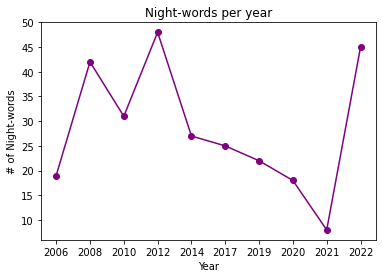

In [ ]:
import matplotlib.pyplot as plt

plt.plot(yearly_mentions.album_year,yearly_mentions.contains_night_words, color='purple', marker='o')
plt.title('Night-words per year')
plt.xlabel('Year')
plt.ylabel('# of Night-words')
plt.show()

#**7. What albums are the most night/day focused?**

### *Add the album title*

In [ ]:
def album_title_insert(row):  
    if row["album_year"] == "2006":
        return 'Taylor Swift'
    elif row['album_year'] == '2008':
        return 'Fearless (Taylor’s Version)'
    elif row['album_year'] == '2010':
        return 'Speak Now (Deluxe)'
    elif row['album_year'] == '2012':
        return 'Red (Deluxe Edition)'
    elif row['album_year'] == '2014':
        return '1989 (Deluxe)'
    elif row['album_year'] == '2017':
        return 'reputation'
    elif row['album_year'] == '2019':
        return 'Lover'
    elif row['album_year'] == '2020':
        return 'evermore (deluxe version)'

    #ok, we know folklore was actually released in Dec 2020, but this will make our analysis easier
    elif row['album_year'] == '2021':
        return 'folklore (deluxe version)'
    #this is slightly differently formatted because the album name is recorded two ways.
    elif '2022' in row['album_year']:
        return 'midnights'
    
    return 'No Title'

yearly_mentions['album_name'] = yearly_mentions.apply(lambda row: album_title_insert(row), axis=1)
yearly_mentions = yearly_mentions[['album_name', 'album_year', 'has_midnight', 'contains_night_words', 'contains_day_words', "contains_time_words", "contains_war_words"]]

yearly_mentions

,album_name,album_year,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words
0,Taylor Swift,2006,0,19,25,19,5
1,Fearless (Taylor’s Version),2008,0,42,65,60,11
2,Speak Now (Deluxe),2010,0,31,53,34,10
3,Red (Deluxe Edition),2012,1,48,53,66,11
4,1989 (Deluxe),2014,2,27,41,15,9
5,reputation,2017,3,25,25,28,4
6,Lover,2019,0,22,46,12,24
7,evermore (deluxe version),2020,2,18,38,24,38
8,folklore (deluxe version),2021,1,8,17,41,19
9,midnights,2022,10,45,23,30,23


In [ ]:
yearly_mentions.sort_values(by="contains_night_words", ascending = False)

,album_name,album_year,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words
3,Red (Deluxe Edition),2012,1,48,53,66,11
9,midnights,2022,10,45,23,30,23
1,Fearless (Taylor’s Version),2008,0,42,65,60,11
2,Speak Now (Deluxe),2010,0,31,53,34,10
4,1989 (Deluxe),2014,2,27,41,15,9
5,reputation,2017,3,25,25,28,4
6,Lover,2019,0,22,46,12,24
0,Taylor Swift,2006,0,19,25,19,5
7,evermore (deluxe version),2020,2,18,38,24,38
8,folklore (deluxe version),2021,1,8,17,41,19


In [ ]:
yearly_mentions.sort_values(by="contains_day_words", ascending = False)

,album_name,album_year,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words
1,Fearless (Taylor’s Version),2008,0,42,65,60,11
2,Speak Now (Deluxe),2010,0,31,53,34,10
3,Red (Deluxe Edition),2012,1,48,53,66,11
6,Lover,2019,0,22,46,12,24
4,1989 (Deluxe),2014,2,27,41,15,9
7,evermore (deluxe version),2020,2,18,38,24,38
0,Taylor Swift,2006,0,19,25,19,5
5,reputation,2017,3,25,25,28,4
9,midnights,2022,10,45,23,30,23
8,folklore (deluxe version),2021,1,8,17,41,19


In [ ]:
yearly_mentions.sort_values(by="contains_time_words", ascending = False)

,album_name,album_year,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words
3,Red (Deluxe Edition),2012,1,48,53,66,11
1,Fearless (Taylor’s Version),2008,0,42,65,60,11
8,folklore (deluxe version),2021,1,8,17,41,19
2,Speak Now (Deluxe),2010,0,31,53,34,10
9,midnights,2022,10,45,23,30,23
5,reputation,2017,3,25,25,28,4
7,evermore (deluxe version),2020,2,18,38,24,38
0,Taylor Swift,2006,0,19,25,19,5
4,1989 (Deluxe),2014,2,27,41,15,9
6,Lover,2019,0,22,46,12,24


In [ ]:
yearly_mentions.sort_values(by="has_midnight", ascending = False)

,album_name,album_year,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words
9,midnights,2022,10,45,23,30,23
5,reputation,2017,3,25,25,28,4
4,1989 (Deluxe),2014,2,27,41,15,9
7,evermore (deluxe version),2020,2,18,38,24,38
3,Red (Deluxe Edition),2012,1,48,53,66,11
8,folklore (deluxe version),2021,1,8,17,41,19
0,Taylor Swift,2006,0,19,25,19,5
1,Fearless (Taylor’s Version),2008,0,42,65,60,11
2,Speak Now (Deluxe),2010,0,31,53,34,10
6,Lover,2019,0,22,46,12,24


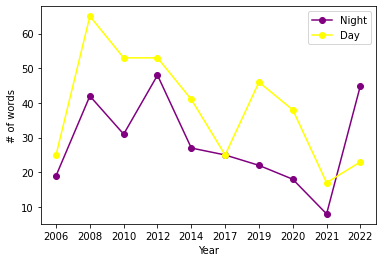

In [ ]:
plt.plot(yearly_mentions.album_year,yearly_mentions.contains_night_words, color='purple', marker='o', label = "Night")
plt.plot(yearly_mentions.album_year,yearly_mentions.contains_day_words, color='yellow', marker='o', label = "Day")
plt.legend()
plt.xlabel('Year')
plt.ylabel('# of words')
plt.show()


#**9. Investigate position of day vs. night mentions within albums**

In [ ]:
df["position"] = df["track_n"] + df["line"]

In [ ]:
positional_mentions = df[["position", "album_year", "has_midnight", "contains_night_words", "contains_day_words", "contains_time_words", "contains_war_words"]]
positional_mentions = positional_mentions.groupby(by="position", axis=0).sum()
positional_mentions = positional_mentions.reset_index()
positional_mentions

,position,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words
0,101,0,0,0,0,0
1,1010,0,0,0,0,0
2,1011,0,0,0,0,0
3,1012,0,0,1,0,1
4,1013,0,0,0,2,0
...,...,...,...,...,...,...
1548,98,0,0,0,0,0
1549,980,0,0,0,0,0
1550,981,0,0,0,0,0
1551,982,0,0,0,0,0


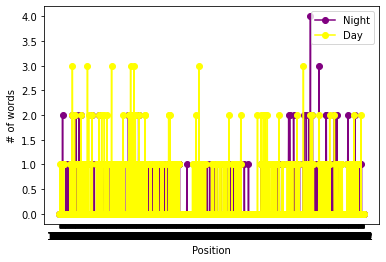

<Figure size 1800x720 with 0 Axes>

In [ ]:
plt.plot(positional_mentions.position,positional_mentions.contains_night_words, color='purple', marker='o', label = "Night")
plt.plot(positional_mentions.position,positional_mentions.contains_day_words, color='yellow', marker='o', label = "Day")
plt.legend()
plt.xlabel('Position')
plt.ylabel('# of words')
plt.show()

fig = plt.gcf()
fig.set_size_inches(25,10)


# **10. Tokenize the Lyrics**

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#run this cell to tokenize the words in the clean_lyric column
df['lyrics_tok'] = df['clean_lyric'].apply(lambda x: word_tokenize(x))
df

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1,2012,walking fast traffic lights,False,False,True,False,False,11,"[walking, fast, traffic, lights]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,Red (Deluxe Edition),State of Grace,1,Busy streets and busy lives,2,2012,busy streets busy lives,False,False,False,False,False,12,"[busy, streets, busy, lives]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,Red (Deluxe Edition),State of Grace,1,And all we know is touch and go,3,2012,touch,False,False,False,False,False,13,[touch],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3,Red (Deluxe Edition),State of Grace,1,We are alone with our changing minds,4,2012,changing minds,False,False,False,False,False,14,"[changing, minds]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,Red (Deluxe Edition),State of Grace,1,We fall in love 'til it hurts or bleeds,5,2012,fall love hurts bleeds,False,False,False,False,False,15,"[fall, love, hurts, bleeds]","{'neg': 0.333, 'neu': 0.215, 'pos': 0.452, 'co...",0.333,0.215,0.452,0.2732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,Midnights (3am Edition),Dear Reader,20,"Guiding light, but I shine so bright",41,2022,guiding light shine bright,False,False,True,False,False,2041,"[guiding, light, shine, bright]","{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.000,0.508,0.492,0.4404
9379,Midnights (3am Edition),Dear Reader,20,You should find another,42,2022,,False,False,False,False,False,2042,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9380,Midnights (3am Edition),Dear Reader,20,You should find another,43,2022,,False,False,False,False,False,2043,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9381,Midnights (3am Edition),Dear Reader,20,Find another,44,2022,,False,False,False,False,False,2044,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000


In [ ]:
import collections as cl
#create a list of all the words in the lyrics_tok column
word_list = [word for list_ in df['lyrics_tok'] for word in list_]

cnt = cl.Counter()

for word in word_list:
    cnt[word] += 1
cnt.most_common()

[('love', 323),
 ('na', 289),
 ('time', 286),
 ('baby', 191),
 ('wan', 168),
 ('right', 166),
 ('ill', 150),
 ('stay', 128),
 ('night', 126),
 ('home', 121),
 ('gon', 121),
 ('good', 108),
 ('feel', 107),
 ('bad', 96),
 ('away', 94),
 ('wish', 94),
 ('better', 93),
 ('girl', 92),
 ('eyes', 90),
 ('new', 86),
 ('knew', 84),
 ('long', 82),
 ('shake', 81),
 ('’', 78),
 ('red', 76),
 ('little', 74),
 ('best', 69),
 ('life', 69),
 ('mind', 68),
 ('forever', 68),
 ('break', 68),
 ('coming', 67),
 ('heart', 66),
 ('face', 65),
 ('leave', 65),
 ('remember', 64),
 ('day', 64),
 ('thought', 64),
 ('dancing', 63),
 ('lights', 62),
 ('gone', 60),
 ('friends', 60),
 ('man', 60),
 ('waiting', 58),
 ('smile', 57),
 ('beautiful', 55),
 ('wanted', 51),
 ('car', 51),
 ('lost', 51),
 ('end', 51),
 ('hands', 50),
 ('room', 49),
 ('walk', 49),
 ('miss', 49),
 ('hand', 49),
 ('hope', 48),
 ('left', 48),
 ('mad', 48),
 ('head', 47),
 ('mean', 47),
 ('hold', 47),
 ('wrong', 46),
 ('door', 46),
 ('place', 46),

#**11. Analyze Lyric Sentiment**

In [ ]:
#run this cell to add a package from NLTK for our sentiment analyzer.
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
#run this cell to see how the sentiment analyzer works
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love Taylor Swift!")

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.7424}

In [ ]:
#create a new column called polarity and apply the sia method to the clean_lyric column with a lambda expression
## YOUR CODE HERE ##
df['polarity'] = df['clean_lyric'].apply(lambda x: sia.polarity_scores(x))
df

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1,2012,walking fast traffic lights,False,False,True,False,False,11,"[walking, fast, traffic, lights]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,Red (Deluxe Edition),State of Grace,1,Busy streets and busy lives,2,2012,busy streets busy lives,False,False,False,False,False,12,"[busy, streets, busy, lives]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,Red (Deluxe Edition),State of Grace,1,And all we know is touch and go,3,2012,touch,False,False,False,False,False,13,[touch],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3,Red (Deluxe Edition),State of Grace,1,We are alone with our changing minds,4,2012,changing minds,False,False,False,False,False,14,"[changing, minds]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,Red (Deluxe Edition),State of Grace,1,We fall in love 'til it hurts or bleeds,5,2012,fall love hurts bleeds,False,False,False,False,False,15,"[fall, love, hurts, bleeds]","{'neg': 0.333, 'neu': 0.215, 'pos': 0.452, 'co...",0.333,0.215,0.452,0.2732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,Midnights (3am Edition),Dear Reader,20,"Guiding light, but I shine so bright",41,2022,guiding light shine bright,False,False,True,False,False,2041,"[guiding, light, shine, bright]","{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.000,0.508,0.492,0.4404
9379,Midnights (3am Edition),Dear Reader,20,You should find another,42,2022,,False,False,False,False,False,2042,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9380,Midnights (3am Edition),Dear Reader,20,You should find another,43,2022,,False,False,False,False,False,2043,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000
9381,Midnights (3am Edition),Dear Reader,20,Find another,44,2022,,False,False,False,False,False,2044,[],"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,0.000,0.000,0.0000


In [ ]:
#run this cell to transform the polarity dictionary into columns of the DataFrame
df[['neg', 'neu', 'pos', 'compound']] = df['polarity'].apply(pd.Series)
df.drop('polarity', axis=1)

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,has_midnight,contains_night_words,contains_day_words,contains_time_words,contains_war_words,position,lyrics_tok,neg,neu,pos,compound
0,Red (Deluxe Edition),State of Grace,1,I'm walking fast through the traffic lights,1,2012,walking fast traffic lights,False,False,True,False,False,11,"[walking, fast, traffic, lights]",0.000,1.000,0.000,0.0000
1,Red (Deluxe Edition),State of Grace,1,Busy streets and busy lives,2,2012,busy streets busy lives,False,False,False,False,False,12,"[busy, streets, busy, lives]",0.000,1.000,0.000,0.0000
2,Red (Deluxe Edition),State of Grace,1,And all we know is touch and go,3,2012,touch,False,False,False,False,False,13,[touch],0.000,1.000,0.000,0.0000
3,Red (Deluxe Edition),State of Grace,1,We are alone with our changing minds,4,2012,changing minds,False,False,False,False,False,14,"[changing, minds]",0.000,1.000,0.000,0.0000
4,Red (Deluxe Edition),State of Grace,1,We fall in love 'til it hurts or bleeds,5,2012,fall love hurts bleeds,False,False,False,False,False,15,"[fall, love, hurts, bleeds]",0.333,0.215,0.452,0.2732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,Midnights (3am Edition),Dear Reader,20,"Guiding light, but I shine so bright",41,2022,guiding light shine bright,False,False,True,False,False,2041,"[guiding, light, shine, bright]",0.000,0.508,0.492,0.4404
9379,Midnights (3am Edition),Dear Reader,20,You should find another,42,2022,,False,False,False,False,False,2042,[],0.000,0.000,0.000,0.0000
9380,Midnights (3am Edition),Dear Reader,20,You should find another,43,2022,,False,False,False,False,False,2043,[],0.000,0.000,0.000,0.0000
9381,Midnights (3am Edition),Dear Reader,20,Find another,44,2022,,False,False,False,False,False,2044,[],0.000,0.000,0.000,0.0000


#**12. Corpus Sentiment Analysis**

In [ ]:
#calculate overall sentiment for pos, neg, sentiment
#print the overall sentiments
df[["neg", "pos", "compound"]].sum()

neg         1172.6690
pos         1624.8110
compound     381.4939
dtype: float64

In [ ]:
#Use the groupby function and matplotlib to visualize the overall sentiment of her albums over time
sentiment_analysis = df[["album_year", "neg", "pos", "compound"]]
sentiment_analysis = sentiment_analysis.groupby(by="album_year", axis=0).sum()
sentiment_analysis = sentiment_analysis.reset_index()
sentiment_analysis

,album_year,neg,pos,compound
0,2006,53.026,114.269,43.4384
1,2008,133.999,216.532,80.5486
2,2010,128.802,154.407,19.5549
3,2012,113.355,174.520,52.6134
4,2014,150.632,201.109,59.4327
5,2017,111.211,165.144,34.8263
6,2019,123.571,180.908,38.6421
7,2020,131.889,145.193,9.8968
8,2021,99.197,110.273,9.0034
9,2022,126.987,162.456,33.5373


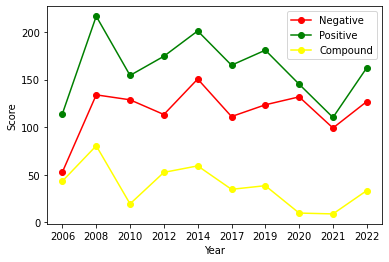

In [ ]:
plt.plot(sentiment_analysis.album_year,sentiment_analysis.neg, color='red', marker='o', label = "Negative")
plt.plot(sentiment_analysis.album_year,sentiment_analysis.pos, color='green', marker='o', label = "Positive")
plt.plot(sentiment_analysis.album_year,sentiment_analysis.compound, color='yellow', marker='o', label = "Compound")

plt.legend()
plt.xlabel('Year')
plt.ylabel('Score')
plt.show()

#**13. Day or Night? Positive or Negative**

In [ ]:
#create a DataFrame filtered for only night mentions
## YOUR CODE HERE ##
df_night = df[df['contains_night_words'] == True] 
df_night = df_night[["album_name", "track_title", "lyric", "clean_lyric","lyrics_tok","contains_night_words", "compound"]]

#create a DataFrame filtered for only day mentions
df_day = df[df['contains_day_words'] == True] 
df_day = df_day[["album_name", "track_title", "lyric", "clean_lyric","lyrics_tok","contains_day_words", "compound"]]

#print the length of the night and day DataFrames
print("Cantidad de lyrics con night: ",len(df_night))
print("Cantidad de lyrics con day: ",len(df_day))

Cantidad de lyrics con night:  285
Cantidad de lyrics con day:  386


In [ ]:
#calculate the sentiment of each day and night DataFrame from the compound values
print("The compound value for night is: ", round(df_night["compound"].sum(),2))

#print the results
print("The compound value for day is: ", round(df_day["compound"].sum(),2))

The compound value for night is:  9.85
The compound value for day is:  10.89
